In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from classification_utils import *

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import VotingClassifier

%matplotlib inline


#from keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot

#from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# set random number generator's seed:
np.random.seed(957)

This function loads the data from a CSV file into panda dataframe:

In [20]:
def load_dataset(filepath):
    data_frame = pd.read_csv(filepath, usecols=['id', 'text', 'intent'])
    data_frame = data_frame.sample(frac=1).reset_index(drop=True)  # shuffle the dataset for better performance in case it's sorted
    return data_frame

load_from_database()
dataset = load_dataset("data/classifier_ds.csv")
dataset.tail()

,id,text,intent
8231,3535.0,"good good, hahahaha :D",none
8232,7622.0,"Hi, any one here ?",greet
8233,6223.0,ok i am ready,none
8234,215.0,i mean num of bead put as what,none
8235,843.0,"@yara : you are make a meeting at 8 pm isA ,, ...",schedule_meeting


In [21]:
dataset.drop(['id'], axis=1).describe()

,text,intent
count,8236,8236
unique,7662,13
top,ok,none
freq,44,2617


In [22]:
# Drop low frequency tags
#dataset = dataset[~dataset.intent.isin(['report_issue'])]
# drop some samples from the 'other' class to make the classes more balanced
#indecies = dataset.index[dataset.tag.isin(['other'])]
#dataset = dataset.drop(np.random.choice(indecies, 1000, replace=False))
#indecies = dataset.index[dataset.tag.isin(['task'])]
#dataset = dataset.drop(np.random.choice(indecies, 1000, replace=False))

In [23]:
stats = dataset[['text','intent']].groupby('intent').count().sort_values(by=['text'])
stats

,text
intent,
report_issue,111
query_rules,122
query_plan,173
query_progress,188
state_rules,233
schedule_meeting,360
report_progress,465
give_feedback,468
request_feedback,488


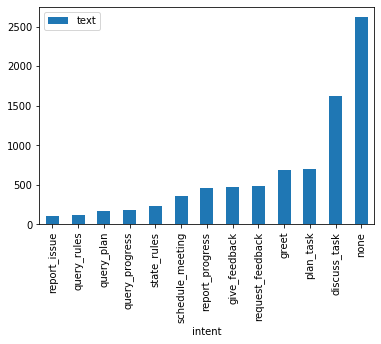

In [24]:
stats.plot.bar(ylim=0)

In [25]:
X = np.reshape(dataset['text'].values, (-1, 1))
Y = np.reshape(dataset['intent'].values, (-1, 1))

In [26]:
# remove empty lines
dataset['text'].dropna(inplace=True)
# remove CSV quotations
dataset['intent'] = dataset.intent.apply(lambda x: str(x).strip('"'))

In [57]:
entities = {
    'person': 'replace', 
    'subteam': 'replace', 
    'tool': 'replace', 
    'artifact': 'replace',
    'time': 'replace',
    'date': 'replace',
    'url': 'replace',
    'email': 'remove',
    'number': 'replace'
}

ids = []
text = []
first_person = []
second_person = []
third_person = []
past_count = []
present_count = []
future_count = []
q_scores = []
r_scores = []
s_scores = []
p_scores = []
n_scores = []
abs_len = []

for _idx, row in dataset.iterrows():
    txt, first, second, third, past, present, future, qscr, rscr, sscr, pscr, nscr, alen = normalize_msg(row.text, normal='none', remove_stop=False, entities=entities)
    ids.append(row.id)
    text.append(txt)
    first_person.append(first)
    second_person.append(second)
    third_person.append(third)
    past_count.append(past)
    present_count.append(present)
    future_count.append(future)
    q_scores.append(qscr)
    r_scores.append(rscr)
    s_scores.append(sscr)
    p_scores.append(pscr)
    n_scores.append(nscr)
    abs_len.append(alen)
    
nds = pd.DataFrame({
    'id': ids,
    'text': text,
    'first_person': first_person,
    'second_person': second_person,
    'third_person': third_person,
    'past_count': past_count,
    'present_count': present_count,
    'future_count': future_count,
    'que_score': q_scores,
    'req_score': r_scores,
    'sug_score': s_scores,
    'pos_score': p_scores,
    'neg_score': n_scores,
    'length': abs_len
})
nds['intent'] = dataset['intent']
nds.dropna(inplace=True)
nds.tail()

,id,text,first_person,second_person,third_person,past_count,present_count,future_count,que_score,req_score,sug_score,pos_score,neg_score,length,intent
8231,3535.0,good good hahahaha d,0,0,0,0,0,0,0.0,0,0.0,2.0,0.0,4,none
8232,7622.0,hi any one here ?,0,0,0,0,0,0,1.0,0,0.0,-0.5,-0.5,5,greet
8233,6223.0,ok i am ready,1,0,0,0,1,0,0.0,-1,0.0,1.0,0.0,4,none
8234,215.0,i mean num of bead put as what,1,0,0,1,1,0,0.5,-1,0.0,0.0,0.0,8,none
8235,843.0,MABotPerson you are make a meeting at MABotE...,0,1,0,0,1,0,1.0,0,0.0,0.5,-0.5,11,schedule_meeting


In [58]:
#Train_X_raw, Test_X_raw, Train_Y_raw, Test_Y_raw = train_test_split(nds.drop(['intent'], axis=1), nds['intent'], test_size=0.2)
#test_ids = Test_X_raw['id']
#test_ids.to_csv('test_ids.csv', index=False)

In [89]:
test_set_ids = pd.read_csv('test_ids.csv', header=None, names=['id'])
Train_raw = nds[~nds['id'].isin(test_set_ids['id'])]
Test_raw = nds[nds['id'].isin(test_set_ids['id'])]

Train_X_raw = Train_raw.drop(['intent'], axis=1)
Train_Y_raw = Train_raw['intent']
Test_X_raw = Test_raw.drop(['intent'], axis=1)
Test_Y_raw = Test_raw['intent']

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y_raw)
Test_Y = Encoder.fit_transform(Test_Y_raw)

In [90]:
pronoun_features = ['first_person', 'second_person', 'third_person']
tense_features = ['past_count', 'present_count', 'future_count']
length_features = ['length']
da_features = ['que_score', 'req_score', 'sug_score', 'pos_score', 'neg_score']

numeric_features = pronoun_features + tense_features + da_features + length_features
heuristic_selection = ['second_person', 'past_count', 'future_count', 'que_score', 'req_score', 'pos_score', 'length']

preprocessor = ColumnTransformer(
    [
        ('txt', TfidfVectorizer(max_features=4000, ngram_range=(1, 3)), 'text'),
        ('num1', MinMaxScaler(feature_range=(1, 10)), tense_features),
        ('num2', MinMaxScaler(feature_range=(1, 10)), pronoun_features),
        ('num3', MinMaxScaler(feature_range=(1, 10)), length_features),
        ('num4', MinMaxScaler(feature_range=(1, 20)), da_features)
        #('num5', MinMaxScaler(feature_range=(1, 10)), heuristic_selection)
    ])

preprocessor.fit(nds.drop(['intent','id'], axis=1))
Train_X = preprocessor.transform(Train_X_raw.drop(['id'], axis=1))
Test_X = preprocessor.transform(Test_X_raw.drop(['id'], axis=1))

print("Training set shape:",Train_X.shape)
print("Test set shape:",Test_X.shape)


intents = list(Encoder.inverse_transform([i for i in range(0, 13)]))

Training set shape: (6402, 4012)
Test set shape: (1596, 4012)


In [91]:
# Random Classifier
import random

accum = 0
dist = []
for intent in stats.index:
    count = stats['text'][intent]
    accum += count
    dist.append((accum, intent))

preds = []
for i in range(Test_Y.shape[0]):
    pred_i = random.randint(1, accum)
    for max_i, intent in dist:
        if pred_i <= max_i:
            preds.append(intent)
            break
    
pred_rand = Encoder.transform(preds)
# Use accuracy_score function to get the accuracy
print("Random Classifier Accuracy Score: %0.2f" % (accuracy_score(pred_rand, Test_Y) * 100))
print("Random Classifier Macro F1 Score: %0.3f" % (f1_score(pred_rand, Test_Y, average='macro')))
print("----------------------------------------------------------")
print(classification_report(Test_Y, pred_rand, target_names=intents))

Random Classifier Accuracy Score: 17.29
Random Classifier Macro F1 Score: 0.073
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.24      0.21      0.23       357
   give_feedback       0.01      0.01      0.01        84
           greet       0.09      0.08      0.09       143
            none       0.32      0.33      0.33       496
       plan_task       0.09      0.09      0.09       120
      query_plan       0.03      0.04      0.03        28
  query_progress       0.03      0.04      0.03        28
     query_rules       0.00      0.00      0.00        20
    report_issue       0.04      0.04      0.04        24
 report_progress       0.04      0.04      0.04       100
request_feedback       0.02      0.02      0.02        86
schedule_meeting       0.01      0.02      0.01        64
     state_rules       0.03      0.02      0.02        46

        accuracy                           0.17

In [95]:
# Rule-based classifier

def simple_classifier(text:str, first_person, second_person, third_person,
                      past_count, present_count, future_count,
                      que_score, req_score, sug_score, pos_score, neg_score, length):
    tokens = text.split()
    contact = 0
    artifact = 0
    tool = 0
    time = 0
    date = 0
    url = 0
    number = 0
    reader = csv.reader(open('data/lexicon2.csv'))
    lex_dict = {}
    for row in reader:
        key = row[0].lower()
        val = row[1].lower()
        lex_dict[key] = val
    intent_scores = {
        'rules': 0,
        'report_issue': 0,
        'schedule_meeting': 0,
        'progress': 0,
        'give_feedback': 0,
        'request_feedback': 0,
        'plan': 0,
        'discuss_task': 0,
        'greet': 0,

    }
    i = 0
    while i < len(tokens):
        t = tokens[i]
        # count special tokens (named entities)
        if t == replacement_dict['person'].strip() or t == replacement_dict['subteam'].strip():
            contact += 1
        elif t == replacement_dict['artifact'].strip():
            artifact += 1
        elif t == replacement_dict['tool'].strip():
            tool += 1
        elif t == replacement_dict['time'].strip():
            time += 1
        elif t == replacement_dict['date'].strip():
            date += 1
        elif t == replacement_dict['url'].strip():
            url += 1
        elif t == replacement_dict['number'].strip():
            number += 1
        # search for intent clues
        largest_match = ''  # index of largest matched key in filtered expressions dictionary
        largest_len = 0
        filtered_dict = filter_dict(lex_dict, t)
        for key in filtered_dict:
            key_tokens = str(key).split(' ')
            match = False
            for ktoken in range(len(key_tokens)):
                if i + ktoken >= len(tokens) or tokens[i + ktoken] != key_tokens[ktoken]:
                    match = False
                    break
                else:
                    match = True
            if match:  # matched all key tokens
                if len(key_tokens) > largest_len:
                    largest_match = key  # save matched key
                    largest_len = len(key_tokens)
        if largest_match:  # found matching key
            intent = filtered_dict[largest_match]
            intent_scores[intent] += 1
            i += largest_len
            continue
        i += 1  # while loop counter
        
    # rule-based classification
    if intent_scores['progress'] > 0 and (past_count > 0 or present_count > 0):
        intent_scores['progress'] += 1
        
    if intent_scores['plan'] > 0 and (future_count > 0):
        intent_scores['plan'] += 1
        
    if intent_scores['request_feedback'] and req_score > 0:
        intent_scores['request_feedback'] += 1
        
    if intent_scores['give_feedback'] and (pos_score > 0 or neg_score > 0):
        intent_scores['give_feedback'] += 1
        
    if intent_scores['schedule_meeting'] > 0 and (future_count > 0):
        intent_scores['schedule_meeting'] += 1
        
    if date > 0:  # schedule
        intent_scores['plan'] += 0.5
        intent_scores['schedule_meeting'] += 0.5
    if time > 0: 
        intent_scores['schedule_meeting'] += 0.5
    if tool > 0:
        intent_scores['rules'] += 1
    if length > 15 and (artifact > 0 or tool > 0 or url > 0):  # technical details
        intent_scores['discuss_task'] += 1
        
    # prioritize important categories
    if que_score > 0:
        if intent_scores['rules'] > 0:
            return 'query_rules'
        elif intent_scores['progress'] > 0:
            return 'query_progress'
        elif intent_scores['plan'] > 0:
            return 'query_plan'
    elif intent_scores['report_issue'] > 0:
        return 'report_issue'
    
    largest_score = 0
    largest_intents = []
    for k, v in intent_scores.items():
        if v >= largest_score and v > 0:
            largest_intents.append(k)
            
    if len(largest_intents) == 1:
        if 'plan' in largest_intents:
            return 'plan_task'
        
        if 'progress' in largest_intents:
            return 'report_progress'
        
        if 'rules' in largest_intents:
            return 'state_rules'
        
        return largest_intents[0]
    else:
        # disambiguation rules
        if 'plan' in largest_intents and 'schedule_meeting' in largest_intents:
            if artifact > 0 or tool > 0 or url > 0:
                return 'plan_task'
            else:
                return 'schedule_meeting'
            
        if 'progress' in largest_intents and 'request_feedback' in largest_intents:
            if req_score > 0:
                return 'request_feedback'
            else:
                return 'report_progress'
            
        if 'plan' in largest_intents:
            return 'plan_task'
        
        if 'progress' in largest_intents:
            return 'report_progress'
        
        if 'rules' in largest_intents:
            return 'state_rules'
        
        if len(largest_intents) > 0:
            return largest_intents[0]
        
    if largest_score == 0:
        if future_count > 0 and first_person > 0:
            return 'plan_task'
        if past_count + present_count > future_count and first_person > (second_person + third_person): 
            return 'report_progress'
        if length > 5 and (artifact > 0 or tool > 0 or url > 0):  # technical details
            return 'discuss_task'
        else:
            return 'none'

rb_preds = []
for _idx, row in Test_X_raw.iterrows():
    pred = simple_classifier(row.text, row.first_person, row.second_person, row.third_person,
                               row.past_count, row.present_count, row.future_count,
                               row.que_score, row.req_score, row.sug_score, row.pos_score, row.neg_score,
                               row.length
                              )
    rb_preds.append(pred)
rb_preds = Encoder.transform(rb_preds)

# Use accuracy_score function to get the accuracy
print("Pattern matching Accuracy Score: %0.2f" % (accuracy_score(rb_preds, Test_Y) * 100))
print("Pattern matching Macro F1 Score: %0.3f" % (f1_score(rb_preds, Test_Y, average='macro')))
print("----------------------------------------------------------")
print(classification_report(Test_Y, rb_preds, target_names=intents))

Pattern matching Accuracy Score: 45.05
Pattern matching Macro F1 Score: 0.378
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.44      0.19      0.27       357
   give_feedback       0.44      0.25      0.32        84
           greet       0.83      0.83      0.83       143
            none       0.48      0.66      0.55       496
       plan_task       0.38      0.30      0.34       120
      query_plan       0.29      0.18      0.22        28
  query_progress       0.50      0.29      0.36        28
     query_rules       0.27      0.20      0.23        20
    report_issue       0.25      0.42      0.31        24
 report_progress       0.20      0.43      0.27       100
request_feedback       0.62      0.29      0.40        86
schedule_meeting       0.46      0.66      0.54        64
     state_rules       0.28      0.26      0.27        46

        accuracy                           0.45  

### Naive Bayes Classifier

In [93]:
# fit the training dataset on the NB classifier
#Naive = naive_bayes.MultinomialNB()
Naive = naive_bayes.ComplementNB(alpha=2) #imbalanced dataset
Naive.fit(Train_X, Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score: %0.2f" % (accuracy_score(predictions_NB, Test_Y) * 100))
print("Naive Bayes Macro F1 Score: %0.3f" % (f1_score(predictions_NB, Test_Y, average='macro')))
print("----------------------------------------------------------")
print(classification_report(Test_Y, predictions_NB, target_names=intents))

Naive Bayes Accuracy Score: 68.05
Naive Bayes Macro F1 Score: 0.508
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.76      0.79      0.78       357
   give_feedback       0.78      0.25      0.38        84
           greet       0.88      0.86      0.87       143
            none       0.63      0.85      0.72       496
       plan_task       0.60      0.55      0.57       120
      query_plan       0.45      0.18      0.26        28
  query_progress       0.60      0.32      0.42        28
     query_rules       1.00      0.15      0.26        20
    report_issue       0.36      0.17      0.23        24
 report_progress       0.73      0.49      0.59       100
request_feedback       0.55      0.69      0.61        86
schedule_meeting       0.71      0.58      0.64        64
     state_rules       0.56      0.20      0.29        46

        accuracy                           0.68      1596
 

### SVM Classifier

In [16]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
#SVM = svm.SVC(C=5, kernel='linear', degree=3, gamma='auto')
SVM = svm.LinearSVC(C=2.5, dual=False)

SVM.fit(Train_X,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score: %0.2f"%(accuracy_score(predictions_SVM, Test_Y) * 100))
print("SVM Macro F1 Score: %0.3f"%f1_score(predictions_SVM, Test_Y, average='macro'))
print("----------------------------------------------------------")
print(classification_report(Test_Y, predictions_SVM, target_names=intents))

SVM Accuracy Score: 70.68
SVM Macro F1 Score: 0.618
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.78      0.77      0.77       357
   give_feedback       0.65      0.48      0.55        84
           greet       0.94      0.85      0.89       143
            none       0.69      0.79      0.74       496
       plan_task       0.54      0.63      0.58       120
      query_plan       0.62      0.54      0.58        28
  query_progress       0.68      0.54      0.60        28
      query_tool       0.64      0.45      0.53        20
    report_issue       0.44      0.33      0.38        24
 report_progress       0.70      0.64      0.67       100
request_feedback       0.60      0.59      0.60        86
schedule_meeting       0.73      0.69      0.71        64
      state_tool       0.59      0.35      0.44        46

        accuracy                           0.71      1596
       macro avg 

In [17]:
test_str = ["Hello Abdelrahman, how are you ?", "Ahmed will do the design", "I just finished the ERD", "Tomorrow is the project deadline!", "we need to build a desktop app", "The relation between the two tables is one to one"]
cols = np.delete(nds.columns.values, [0, 14])
normalized_test = [normalize_msg(tst, remove_stop=False, normal='None') for tst in test_str]
test_df = pd.DataFrame(normalized_test, columns=cols)
pred = SVM.predict(preprocessor.transform(test_df))
Encoder.inverse_transform(pred)

array(['greet', 'plan_task', 'report_progress', 'plan_task', 'none',
       'discuss_task'], dtype=object)


### Logistic Regression Classifier

In [18]:
logReg = LogisticRegression(C=10, multi_class='ovr', class_weight='balanced', solver='liblinear')
logReg.fit(Train_X, Train_Y)

# test and print accuracy
LogRegPredictions = logReg.predict(Test_X)
score = accuracy_score(LogRegPredictions, Test_Y) * 100
f1 = f1_score(LogRegPredictions, Test_Y, average='macro')
print("Logistic Regression Accuracy: %0.2f"%score)
print("Logistic Regression Macro F1 Score: %0.3f"% f1)
print("----------------------------------------------------------")
print(classification_report(Test_Y, LogRegPredictions, target_names=intents))


Logistic Regression Accuracy: 70.24
Logistic Regression Macro F1 Score: 0.614
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.81      0.78      0.79       357
   give_feedback       0.57      0.55      0.56        84
           greet       0.94      0.88      0.91       143
            none       0.75      0.69      0.72       496
       plan_task       0.51      0.68      0.58       120
      query_plan       0.50      0.54      0.52        28
  query_progress       0.52      0.54      0.53        28
      query_tool       0.43      0.50      0.47        20
    report_issue       0.37      0.42      0.39        24
 report_progress       0.66      0.71      0.69       100
request_feedback       0.58      0.67      0.62        86
schedule_meeting       0.70      0.75      0.72        64
      state_tool       0.50      0.46      0.48        46

        accuracy                           0.70  

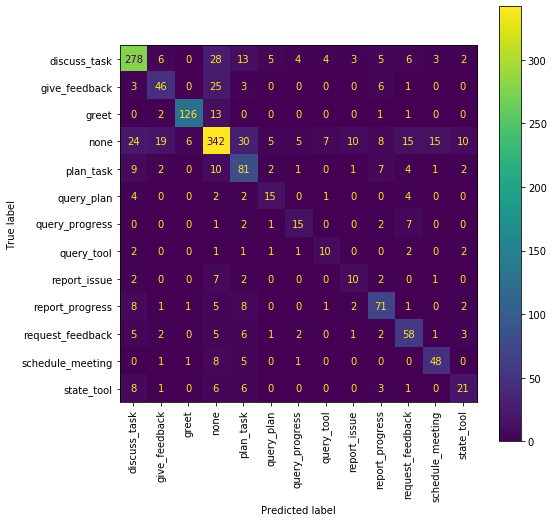

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(logReg, Test_X, Test_Y, display_labels=intents, xticks_rotation='vertical', ax=ax)

In [20]:
# Simple Majority Voting Ensemble (depends on previous classifiers predictions)
#sum_pred = LogRegPredictions.todense() + predictions_SVM.todense() + predictions_NB.todense()

eclf = VotingClassifier(estimators=[ ('nb', Naive), ('svm', SVM),('lr', logReg)], voting='hard')
eclf.fit(Train_X, Train_Y)
ensemble_pred = eclf.predict(Test_X)

#ensemble_pred
score = accuracy_score(ensemble_pred, Test_Y) * 100
f1 = f1_score(ensemble_pred, Test_Y, average='macro')
print("Majority Voting Accuracy: %0.2f"% score)
print("Majority Voting F1 Score: %0.3f"% f1)
print("----------------------------------------------------------")
print(classification_report(Test_Y, ensemble_pred, target_names=intents, digits=2))

Majority Voting Accuracy: 72.12
Majority Voting F1 Score: 0.625
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.78      0.80      0.79       357
   give_feedback       0.66      0.48      0.55        84
           greet       0.93      0.86      0.89       143
            none       0.72      0.78      0.75       496
       plan_task       0.57      0.68      0.62       120
      query_plan       0.58      0.50      0.54        28
  query_progress       0.62      0.54      0.58        28
      query_tool       0.69      0.45      0.55        20
    report_issue       0.40      0.33      0.36        24
 report_progress       0.76      0.66      0.71       100
request_feedback       0.60      0.67      0.64        86
schedule_meeting       0.73      0.69      0.71        64
      state_tool       0.55      0.37      0.44        46

        accuracy                           0.72      1596
     

# Error Analyses

In [35]:
predictions = rb_preds
expected = Encoder.inverse_transform(Test_Y)
actual = Encoder.inverse_transform(predictions)
errors = errors = np.zeros((len(intents), len(intents)))
for ex in range(0, Test_X.shape[0]):
    if actual[ex] != expected[ex]:
        errors[Test_Y[ex]][predictions[ex]] += 1

In [36]:
print("%7.5s"*(len(intents)+2) %('', *intents, 'Total'))
for i in range(0, len(intents)):
    print("%7.5s"*(len(intents)+2) %(intents[i], *errors[i], sum(errors[i])))
print("%7.5s"*(len(intents)+2) %("Total", *np.sum(errors, axis=0), ''))

         discu  give_  greet   none  plan_  query  query  query  repor  repor  reque  sched  state  Total
  discu    0.0    0.0    0.0    0.0    0.0    2.0    0.0    4.0    0.0    0.0    0.0  312.0    0.0  318.0
  give_    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0    0.0    0.0   95.0    0.0  102.0
  greet    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  135.0    0.0  135.0
   none    0.0    0.0    0.0    0.0    0.0    3.0    1.0    1.0   11.0    0.0    0.0  510.0    0.0  526.0
  plan_    0.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    2.0    0.0    0.0  118.0    0.0  122.0
  query    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0   23.0    0.0   25.0
  query    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0    0.0    0.0   24.0    0.0   26.0
  query    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   10.0    0.0   10.0
  repor    0.0    0.0    0.0    0.0    0.0    

In [27]:
def get_errors(true_label=None, pred_label=None):
    if true_label:
        true_index = intents.index(true_label)
    if pred_label:
        pred_index = intents.index(pred_label)
    print("Searching for \"", true_label, "\" misclassified as \"", pred_label,"\"")
    error_list = (Test_X_raw[(Test_Y != ensemble_pred) & (Test_Y == true_index) & (ensemble_pred == pred_index)])
    print('found', error_list.shape[0], 'errors')
    return error_list
get_errors('none', "plan_task").drop(['id'], axis=1)

Searching for " none " misclassified as " plan_task "
found 21 errors


,text,first_person,second_person,third_person,past_count,present_count,future_count,que_score,req_score,sug_score,pos_score,neg_score,length
3351,MABotPerson can you send me the images to pu...,1,1,0,0,0,0,1.0,2,0.0,0.0,0.0,12
3832,MABotSubteam i hope hasan joins us later but...,3,0,1,0,1,1,0.5,-1,0.0,0.0,0.0,18
1404,MABotPerson hello MABotPerson please appro...,2,0,0,0,0,1,0.0,1,-0.5,0.0,0.0,14
3203,MABotPerson the work plan i guess,0,0,0,0,1,0,0.0,-1,0.0,0.0,0.0,6
3975,MABotSubteam please see the work plan and pl...,0,0,2,0,0,0,1.0,3,0.0,0.0,0.0,20
2186,MABotPerson i do finish,1,0,0,0,1,0,0.0,-1,0.0,0.0,0.0,4
2646,to let others see it and make a revision from it,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,11
7440,mm i will do as the last MABotArtifact,1,0,0,0,0,1,0.0,-1,0.0,0.0,0.0,8
6634,ok because if we have to upload the MABotArti...,2,0,0,0,1,1,0.0,-2,0.0,0.0,0.0,16
6958,hope we have a productive final day and are ab...,3,0,0,0,2,0,0.0,-2,1.0,0.0,0.0,20
